#### Executing this notebook depends on the Delta tables from project 1 being saved on DBFS!
In project 1, make sure to run chapters 1, 2, 3 fully to save the Delta tables.

### Read data and extract relevant features

In [0]:
import pyspark.sql.functions as F
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [0]:
# Read the full dblp fact table.
dblp_df = (spark
           .read.load(f'dbfs:/user/dblpv13/dblp_full')
           .filter(F.col('Lang') == 'en')) # Keep only papers in English

In [0]:
# Keep just the relevant features: FOS, Keywords, Title, Abstract.
data = dblp_df.select('FOS', 'Keywords', 'Title', 'Abstract')

# Drop all rows where any value is null.
data = data.na.drop()

# Keep only rows where title and abstract are longer than 1 word.
data = (data.filter( (F.size(F.split(data.Title, ' ')) > 1) & 
                     (F.size(F.split(data.Abstract, ' ')) > 1) ))

# Remove all empty (null or '') values from the FOS and Keywords arrays.
data = (data
        .withColumn('FOS', F.expr('filter(FOS, x -> x is not null)'))
        .withColumn('FOS', F.expr('filter(FOS, x -> length(x) > 0)'))
        .withColumn('Keywords', F.expr('filter(Keywords, x -> x is not null)'))
        .withColumn('Keywords', F.expr('filter(Keywords, x -> length(x) > 0)')))

logger.info(f'Our data has {data.count()} samples.')

display(data.limit(10))

In [0]:
!pip install spacy

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
!python -m spacy download en_core_web_sm

In [0]:
import spacy
import re
import string
from pyspark.sql.types import StringType, ArrayType, FloatType
from collections import Counter
import pyspark.sql.functions as F

In [0]:
nlp = spacy.load("en_core_web_sm")

In [0]:
def preprocess(text):
    # remove punctuation
    text = re.sub('[^\w\s]', ' ', text)
    # tokenize text
    text_tokens = text.split(' ')
    text_tokens = [word for word in text_tokens if word != '']
    # remove stopwords
    stopwords = nlp.Defaults.stop_words
    tokens = [word for word in text_tokens if not word in stopwords]
    # lowercase and remove custom stopwords
    custom_stopwords = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'Elsevier', 'PMC', 'CZI', 'www']
    tokens = [token.lower() for token in tokens if token not in custom_stopwords]
    return tokens

preprocessUDF = udf(preprocess, ArrayType(StringType()))

def preprocess_list(arr):
    text = ' '.join(arr)
    # remove punctuation
    text = re.sub('[^\w\s]', ' ', text)
    # tokenize text
    text_tokens = text.split(' ')
    text_tokens = [word for word in text_tokens if word != '']
    # remove stopwords
    stopwords = nlp.Defaults.stop_words
    tokens = [word for word in text_tokens if not word in stopwords]
    # lowercase and remove custom stopwords
    custom_stopwords = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'Elsevier', 'PMC', 'CZI', 'www']
    tokens = [token.lower() for token in tokens if token not in custom_stopwords]
    return tokens

preprocess_listUDF = udf(preprocess_list, ArrayType(StringType()))

In [0]:
processed_data = data.withColumn("FOS", preprocess_listUDF("FOS")) \
                     .withColumn("Keywords", preprocess_listUDF("Keywords")) \
                     .withColumn("ProcessedTitle", preprocessUDF("Title")) \
                     .withColumn("Abstract", preprocessUDF("Abstract"))

In [0]:
display(processed_data.limit(10))

Combine the lists of each row into one in a new column called 'words'.

In [0]:
processed_data = processed_data.withColumn("words", F.concat(processed_data.FOS, processed_data.Keywords, processed_data.ProcessedTitle, processed_data.Abstract))

In [0]:
display(processed_data.limit(10))

Vectorization of the data.

In [0]:
from pyspark.ml.feature import HashingTF, IDF

In [0]:
ht = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1024)
tf_vectors = ht.transform(processed_data.select("title", "words"))
display(tf_vectors.limit(10))

In [0]:
idf = IDF(inputCol="raw_features", outputCol="features", minDocFreq=5)
idf_model = idf.fit(tf_vectors)
tfIdf_vectors = idf_model.transform(tf_vectors)

In [0]:
transformed_data = tfIdf_vectors.select("title", "words", "features").cache()

In [0]:
display(transformed_data.limit(10))

title,words,features
Logic synthesis and verification on fixed topology,"List(logic, synthesis, topology, digital, electronics, boolean, circuit, sequential, logic, pass, transistor, logic, logic, optimization, algorithm, register, transfer, level, high, level, verification, mathematics, combinational, circuits, formal, verification, logic, design, logic, testing, network, topology, sat, combinational, circuits, fixed, circuit, topology, formal, verification, logic, synthesis, logic, verification, minimum, eco, net, lists, test, vector, generation, method, logic, synthesis, verification, fixed, topology, we, discuss, logic, synthesis, formal, verification, combinational, circuits, mapped, given, fixed, topology, here, fixed, topology, means, circuit, structures, terms, net, lists, gate, cell, types, fixed, advance, that, logic, synthesis, generated, types, gates, cells, simply, gates, circuits, prefixed, synthesis, as, circuit, topology, fixed, advance, placement, routing, shared, different, designs, minimum, eco, realized, keeping, layout, also, need, test, vectors, order, guarantee, 100, correctness, synthesis, small, numbers, test, vectors, 100, test, vectors, 30, input, circuits, sufficient, test, circuits, behave, correctly, possible, input, value, combinations, that, efficient, formal, verification, realized, simulations, small, numbers, test, vectors, we, present, sat, based, implementation, synthesis, test, vector, generation, method, preliminary, encouraging, experimental, results)","Map(vectorType -> sparse, length -> 1024, indices -> List(32, 71, 79, 101, 103, 132, 159, 166, 183, 186, 207, 217, 230, 234, 266, 273, 274, 275, 282, 289, 308, 320, 321, 323, 340, 346, 373, 420, 436, 439, 476, 498, 512, 525, 530, 532, 540, 559, 561, 562, 570, 573, 579, 590, 603, 606, 608, 619, 621, 631, 635, 640, 641, 690, 704, 708, 719, 726, 743, 778, 782, 786, 815, 838, 843, 850, 852, 875, 889, 900, 901, 904, 931, 939, 942, 946, 957, 977, 981, 984, 999, 1014), values -> List(5.134472078303298, 2.0248840743542957, 2.2575351336803413, 5.621995754633941, 3.936267267308025, 0.9912765568825117, 4.151979281780988, 3.207599631389355, 1.158953376745861, 3.0982715564639927, 1.739308006781999, 1.1329498276099859, 1.6542659012630216, 6.322634644816358, 2.92908272068124, 5.934369685953658, 3.060404206794744, 4.085830053195118, 1.4789298858485358, 2.224527373176438, 2.719822591860196, 6.082770772589398, 2.987313292644241, 0.724504468187638, 5.118898566284147, 17.904015688723135, 1.7733066553124481, 16.684910488320785, 1.7474019525572908, 3.252196330318888, 15.012674899126921, 2.640136192526237, 3.943839679633637, 1.943081730078655, 2.6122362177918936, 2.211436346086757, 9.30278985409773, 1.8947316543456758, 2.6915333321507693, 1.5181142462583355, 3.665877138375948, 6.757153768352232, 5.784330594291435, 4.282341701571961, 3.1801013949014547, 8.811364174676921, 5.869061787350418, 1.9928501167176582, 21.32727601781457, 3.0081686130407355, 17.223860402400547, 4.366014050963799, 5.462913558283074, 0.7705732805226303, 2.9316533599758228, 2.945951780175727, 3.0583776726516056, 2.438984815839421, 2.0825751568343134, 12.732068062233006, 1.8936097623950336, 1.4152694551977565, 1.5897688128697542, 3.4227496365632333, 1.6477199372171183, 1.8897344799106193, 1.8490800871183224, 3.688340827142819, 4.254650245077087, 22.752795331577186, 2.799423533019719, 4.1119451941925895, 10.49582924916565, 2.588383851991325, 5.267586612937361, 2.6435818849438593, 2.210837710822716, 1.019642881818959, 2.2857456685303608, 3.0297426326572934, 0.4672810490414463, 2.641428229110394))"
Adaptive sequential compressive detection,"List(detection, theory, computer, science, inference, algorithm, artificial, intelligence, fuse, electrical, machine, learning, recursion, adaptive, signal, detection, compressed, sensing, multidimensional, signal, processing, signal, reconstruction, adaptive, sequential, compressive, signal, detection, compressive, gain, multidimensional, phenomena, nonadapt

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import Normalizer, PCA

In [0]:
# using PCA features for clustering
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(transformed_data)
transformed_data = pca_model.transform(transformed_data).cache()
display(transformed_data.limit(10))

title,words,features,pca_features
Logic synthesis and verification on fixed topology,"List(logic, synthesis, topology, digital, electronics, boolean, circuit, sequential, logic, pass, transistor, logic, logic, optimization, algorithm, register, transfer, level, high, level, verification, mathematics, combinational, circuits, formal, verification, logic, design, logic, testing, network, topology, sat, combinational, circuits, fixed, circuit, topology, formal, verification, logic, synthesis, logic, verification, minimum, eco, net, lists, test, vector, generation, method, logic, synthesis, verification, fixed, topology, we, discuss, logic, synthesis, formal, verification, combinational, circuits, mapped, given, fixed, topology, here, fixed, topology, means, circuit, structures, terms, net, lists, gate, cell, types, fixed, advance, that, logic, synthesis, generated, types, gates, cells, simply, gates, circuits, prefixed, synthesis, as, circuit, topology, fixed, advance, placement, routing, shared, different, designs, minimum, eco, realized, keeping, layout, also, need, test, vectors, order, guarantee, 100, correctness, synthesis, small, numbers, test, vectors, 100, test, vectors, 30, input, circuits, sufficient, test, circuits, behave, correctly, possible, input, value, combinations, that, efficient, formal, verification, realized, simulations, small, numbers, test, vectors, we, present, sat, based, implementation, synthesis, test, vector, generation, method, preliminary, encouraging, experimental, results)","Map(vectorType -> sparse, length -> 1024, indices -> List(32, 71, 79, 101, 103, 132, 159, 166, 183, 186, 207, 217, 230, 234, 266, 273, 274, 275, 282, 289, 308, 320, 321, 323, 340, 346, 373, 420, 436, 439, 476, 498, 512, 525, 530, 532, 540, 559, 561, 562, 570, 573, 579, 590, 603, 606, 608, 619, 621, 631, 635, 640, 641, 690, 704, 708, 719, 726, 743, 778, 782, 786, 815, 838, 843, 850, 852, 875, 889, 900, 901, 904, 931, 939, 942, 946, 957, 977, 981, 984, 999, 1014), values -> List(5.134472078303298, 2.0248840743542957, 2.2575351336803413, 5.621995754633941, 3.936267267308025, 0.9912765568825117, 4.151979281780988, 3.207599631389355, 1.158953376745861, 3.0982715564639927, 1.739308006781999, 1.1329498276099859, 1.6542659012630216, 6.322634644816358, 2.92908272068124, 5.934369685953658, 3.060404206794744, 4.085830053195118, 1.4789298858485358, 2.224527373176438, 2.719822591860196, 6.082770772589398, 2.987313292644241, 0.724504468187638, 5.118898566284147, 17.904015688723135, 1.7733066553124481, 16.684910488320785, 1.7474019525572908, 3.252196330318888, 15.012674899126921, 2.640136192526237, 3.943839679633637, 1.943081730078655, 2.6122362177918936, 2.211436346086757, 9.30278985409773, 1.8947316543456758, 2.6915333321507693, 1.5181142462583355, 3.665877138375948, 6.757153768352232, 5.784330594291435, 4.282341701571961, 3.1801013949014547, 8.811364174676921, 5.869061787350418, 1.9928501167176582, 21.32727601781457, 3.0081686130407355, 17.223860402400547, 4.366014050963799, 5.462913558283074, 0.7705732805226303, 2.9316533599758228, 2.945951780175727, 3.0583776726516056, 2.438984815839421, 2.0825751568343134, 12.732068062233006, 1.8936097623950336, 1.4152694551977565, 1.5897688128697542, 3.4227496365632333, 1.6477199372171183, 1.8897344799106193, 1.8490800871183224, 3.688340827142819, 4.254650245077087, 22.752795331577186, 2.799423533019719, 4.1119451941925895, 10.49582924916565, 2.588383851991325, 5.267586612937361, 2.6435818849438593, 2.210837710822716, 1.019642881818959, 2.2857456685303608, 3.0297426326572934, 0.4672810490414463, 2.641428229110394))","Map(vectorType -> dense, length -> 2, values -> List(-7.248651695953982, 2.3996259039120345))"
Adaptive sequential compressive detection,"List(detection, theory, computer, science, inference, algorithm, artificial, intelligence, fuse, electrical, machine, learning, recursion, adaptive, signal, detection, compressed, sensing, multidimensional, signal, processing, signal, reconstruction, a

The elbow method to determine K.

In [0]:
import gc

cost = []

for k in range(2, 7):
    kmeans = KMeans(k=k, seed=3, featuresCol='pca_features', initMode="random")
    model = kmeans.fit(transformed_data)
    clusteredData = model.transform(transformed_data)
    evaluator = ClusteringEvaluator()
    cost.append((k, evaluator.evaluate(clusteredData)))
    gc.collect()

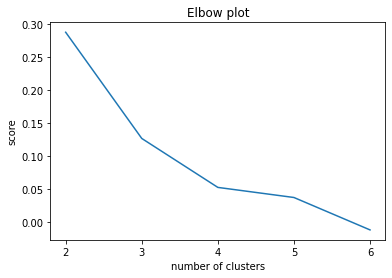

In [0]:
from matplotlib import pyplot as plt

x, y = zip(*cost)
plt.plot(x, y)
plt.title("Elbow plot")
plt.xlabel("number of clusters")
plt.ylabel("score")
plt.xticks(x)
plt.show()

K-means clustering.

In [0]:
kmeans = KMeans(k=4, seed=3, featuresCol='pca_features', initMode='random')
model = kmeans.fit(transformed_data)

In [0]:
clusteredData = model.transform(transformed_data)

In [0]:
display(clusteredData.groupby('prediction').count().orderBy(F.asc('prediction')).limit(10))

prediction,count
0,67635
1,286329
2,52364
3,950460


Search engine.

In [0]:
from pyspark.sql.types import DoubleType

def get_similarity_func(query_vector):
    @udf(DoubleType())
    def dot_product(x):
        return float(x.dot(query_vector))
    
    return dot_product


def recommend(title, data, k=10):
    # L2 normalized vectors (for calculating cosine similarity)
    normalizer = Normalizer(p=2, inputCol="features", outputCol="norm_features")
    normalized_data = normalizer.transform(data)
    
    # our target
    # if duplicate titles exist take first
    row = normalized_data.filter(F.col("title") == title).take(1)[0]
    query_vector = row.norm_features
    cluster = row.prediction
    
    # dot product between our target vector and other vectors, resulting in cosine similarity
    similarity_func = get_similarity_func(query_vector)
    
    return (normalized_data
            .filter(F.col("title") != title) # remove entries with same titles
            .filter(F.col("prediction") == cluster) # choose from the same cluster
            .select("title", similarity_func(F.col("norm_features")).alias("similarity"))
            .orderBy(F.desc('similarity'))
            .take(k))

In [0]:
display(recommend("Logic synthesis and verification on fixed topology", clusteredData))

title,similarity
Design for verification testability,0.6370701127336954
Logic synthesis and verification of the CPU and caches of a mainframe system,0.5597308460164734
Logic verification based on diagnosis techniques,0.5464437180647934
Novel verification framework combining structural and OBDD methods in a synthesis environment,0.5463864019528685
Test-set preserving logic transformations,0.534978194333489
Partial synthesis through sampling with and without specification,0.5215967288500273
Modeling a Hardware Synthesis Methodology in Isabelle,0.513947584796681
Simulation based verification of register-transfer level behavioral synthesis tools,0.5135706776964981
A verification algorithm for logic circuits with internal variables,0.5119061928880225
ABC: An Academic Industrial-Strength Verification Tool,0.5085516574589598


In [0]:
display(recommend("Audio-based gender and age identification", clusteredData))

title,similarity
Age and gender estimation by using facial image,0.5393982409982283
Gender and age estimation from synthetic face images,0.5147377261422899
Mining API Error-Handling Specifications from Source Code,0.5100846913525148
Learning Age and Gender of Blogger from Stylistic Variation,0.5044737934621787
Language independent voice-based gender identification system,0.49941961821282244
Gender classification in two Emotional Speech databases,0.4877962536527561
A software framework for patient data handling in emergencies and disasters,0.48520703028622464
Implementation of age and gender recognition system for intelligent digital signage,0.48443311957927265
APIReal: an API recognition and linking approach for online developer forums.,0.483866870570802
Investigating the impact of gender development in child-robot interaction,0.4749825131104994
